In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import argparse

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import pandas as pd
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os
import argparse
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.models as models
%pip install wandb -q
import wandb
# import Fadml_Assignment_model

Note: you may need to restart the kernel to use updated packages.


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 6, kernel_size =5)
        self.fc1 = nn.Linear(6*5*5, 120)
        self.fc2 = nn.Linear(120, 84 )
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 

def convfc():
    model_arch = Net()
    return model_arch

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
device

'cuda'

In [5]:
# Data
print('Data transformation')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

Data transformation


In [6]:
validation_split = .15


trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# find data indices for training and validation splits:
dataset_size = len(trainset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

train_indices, val_indices = indices[split:], indices[:split]



trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128,num_workers=2,sampler=train_indices)

validationloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, num_workers=2,sampler=val_indices)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# Training
def train(epoch,net,criterion,optimizer,mse=False):
    print('\nEpoch: %d' % epoch)
    net.train()

    running_train_loss = 0.0
    running_valid_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        # Write your code here
        optimizer.zero_grad()
        
        outputs = net(inputs).to(device)
        
        if mse == False:
            loss = criterion(outputs, targets)

        else:
            one_hot_target = torch.nn.functional.one_hot(targets, 10).float()
            loss = criterion(outputs, one_hot_target)

        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    running_loss_history.append(running_train_loss)
    
    losstrain={'epoch': [epoch],'loss':[running_train_loss]}# store epoch and losses dictionary

    loss_df = pd.DataFrame.from_dict(losstrain)# create dataframe from this dictionary
    loss_df.to_csv(r'loss_train.txt', header=None, index=None, sep=' ', mode='a')# dataframe to txt file
    print('Completed Training')
    print('Training Loss: %d' % running_train_loss)
    wandb.log({"Epoch":epoch,"Training Loss": running_train_loss})

    with torch.no_grad(): # gradient for validation not requored
      for val_inputs, val_labels in validationloader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = net(val_inputs)
        
        if mse == False:
            val_loss = criterion(val_outputs, val_labels)
        else:
            one_hot_target = torch.nn.functional.one_hot(val_labels, 10).float()
            val_loss = criterion(val_outputs, one_hot_target)
        
        _, val_preds = torch.max(val_outputs, 1)
        running_valid_loss += val_loss.item()
    val_running_loss_history.append(running_valid_loss)
    wandb.log({"Epoch":epoch,"Validation Loss": running_valid_loss})

In [8]:
def test(epoch,net,criterion,mse):
  global best_acc
  net.eval()
  total = 0
  correct = 0
  test_loss = 0
  test_images = []
  print('\nEpochs: %d' % epoch)
  with torch.no_grad():
      for batch_idx, (inputs, targets) in enumerate(testloader):
          inputs, targets = inputs.to(device), targets.to(device)
          
          outputs = net(inputs)
            
          if mse == False:
            loss = criterion(outputs, targets)

          else:
            one_hot_target = torch.nn.functional.one_hot(targets, 10).float()
            loss = criterion(outputs, one_hot_target)
            
          
          _, predicted = torch.max(outputs.data, 1)# input data prediction

          total += targets.size(0)# total size of the target
          test_loss += loss.item()
          correct += (predicted == targets).sum().item()# correctly classified labels
          
          test_images.append(wandb.Image(inputs[0], caption="Pred: {} Truth: {}".format(predicted[0].item(), targets[0])))
          
      model_accuracy = 100 * correct / total
      print('Testing Accuracy: %d ' % model_accuracy)
      print('\n')
      
      if model_accuracy>best_acc:
      
        best_acc = model_accuracy
        
        
        PATH = './model_cifar.pth'# Save best accuracy model checkpoint
        torch.save(net.state_dict(), PATH)
          
      df={'epoch': [epoch],'loss':[test_loss]}
      data = pd.DataFrame.from_dict(df)
      data.to_csv(r'loss_test.txt', header=None, index=None, sep=' ', mode='a')#for each epoch write test set losses to loss_test.txt 
      
      testaccuracy={'epoch': [epoch],'test_accuracy':[model_accuracy]}
      
      accuracy_df = pd.DataFrame.from_dict(testaccuracy)
      
      accuracy_df.to_csv(r'acc_test.txt', header=None, index=None, sep=' ', mode='a')
      wandb.log({"Epoch":epoch,"Testing images": test_images,"Test Accuracy": 100. * correct / len(testloader.dataset),"Test Loss": test_loss})   
  

In [9]:
def train_test_model(net,criterion,optimizer,mse):
  n_epochs_stop = 5
  epochs_no_improve = 0
  for epoch in range(0,50):
    print("Training Model")
    train(epoch,net,criterion,optimizer,mse)
    if val_running_loss_history[epoch]>val_running_loss_history[epoch-1]:
      if(epochs_no_improve<n_epochs_stop):
        epochs_no_improve+=1
      else:
        break
    else:
      epochs_no_improve=0
    print("\n Training Model")
    test(epoch,net,criterion,mse)

In [23]:
def best_param_prediction(net):
  
#   PATH ='./model_cifar.pth'# Load best model 
#   net.load_state_dict(torch.load(PATH))
  
  correct_pred = {classname: 0 for classname in classes}# per class count predictions
  total_pred = {classname: 0 for classname in classes}

  
  with torch.no_grad():# no gradients required for prediction
      for batch_id, (images, labels) in enumerate(testloader):
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:   
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1


  
  for classname, correct_count in correct_pred.items():# class wise accuracy
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))

In [17]:
def plot_confusion_matrix(net):
  total_correct = 0
  total_images = 0
  confusion_matrix = np.zeros([10,10], int)
  with torch.no_grad():
      for batch_id, (images, labels) in enumerate(testloader):
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total_images += labels.size(0)
          total_correct += (predicted == labels).sum().item()
          for i, l in enumerate(labels):
              confusion_matrix[l.item(), predicted[i].item()] += 1 

  model_accuracy = total_correct / total_images * 100
  print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))
  fig, ax = plt.subplots(1,1,figsize=(8,6))
  sns.heatmap(confusion_matrix,annot = True,fmt='d', cmap="autumn")
  plt.ylabel('Actual Category')
  plt.yticks(range(10), classes)
  plt.xlabel('Predicted Category')
  plt.xticks(range(10), classes)
  plt.show()

Model 1:

Use SGD optimizer with learning rate = 0.001, momentum = 0.9 and cross-entropy as
the loss function.


In [12]:
run=wandb.init(project="50-Epoch_CIFAR-FADML-Utkarsh",reinit=True)
wandb.watch_called = False
net1 = convfc()
wandb.watch(net1,log="all")
net1 = net1.to(device)
running_loss_history = []
val_running_loss_history = []
mse = False
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)
train_test_model(net1,criterion,optimizer,mse)

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training Model

Epoch: 0
Completed Training
Training Loss: 766

 Training Model

Epochs: 0
Testing Accuracy: 15 


Training Model

Epoch: 1
Completed Training
Training Loss: 757

 Training Model

Epochs: 1
Testing Accuracy: 16 


Training Model

Epoch: 2
Completed Training
Training Loss: 712

 Training Model

Epochs: 2
Testing Accuracy: 26 


Training Model

Epoch: 3
Completed Training
Training Loss: 669

 Training Model

Epochs: 3
Testing Accuracy: 30 


Training Model

Epoch: 4
Completed Training
Training Loss: 639

 Training Model

Epochs: 4
Testing Accuracy: 34 


Training Model

Epoch: 5
Completed Training
Training Loss: 607

 Training Model

Epochs: 5
Testing Accuracy: 37 


Training Model

Epoch: 6
Completed Training
Training Loss: 584

 Training Model

Epochs: 6
Testing Accuracy: 38 


Training Model

Epoch: 7
Completed Training
Training Loss: 571

 Training Model

Epochs: 7
Testing Accuracy: 39 


Training Model

Epoch: 8
Completed Training
Training Loss: 557

 Training Model


In [13]:
best_param_prediction(net1)

Accuracy for class plane is: 60.2 %
Accuracy for class car   is: 78.4 %
Accuracy for class bird  is: 30.9 %
Accuracy for class cat   is: 39.0 %
Accuracy for class deer  is: 41.5 %
Accuracy for class dog   is: 49.7 %
Accuracy for class frog  is: 80.3 %
Accuracy for class horse is: 68.4 %
Accuracy for class ship  is: 57.4 %
Accuracy for class truck is: 65.3 %


Model accuracy on 10000 test images: 57.11%


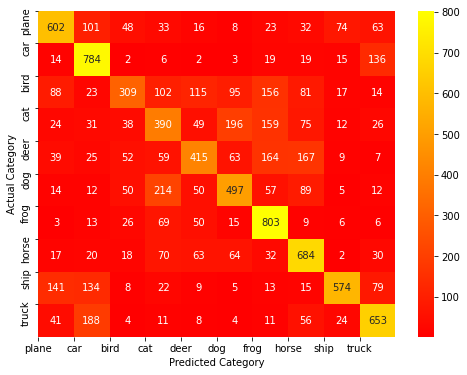

In [18]:
plot_confusion_matrix(net1)

Model 2:

Use Adam optimizer with learning rate = 0.01 and cross-entropy as the loss function

In [21]:
run=wandb.init(project="50-Epoch_CIFAR-FADML-Utkarsh",reinit=True)
wandb.watch_called = False 
net2 = convfc()
wandb.watch(net2,log="all")
net2 = net2.to(device)
running_loss_history = []
val_running_loss_history = []
mse = False
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net2.parameters(), lr=0.01)
train_test_model(net2,criterion,optimizer,mse)

wandb: ERROR Control-C detected -- Run data was not synced


wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training Model

Epoch: 0
Completed Training
Training Loss: 678

 Training Model

Epochs: 0
Testing Accuracy: 30 


Training Model

Epoch: 1
Completed Training
Training Loss: 619

 Training Model

Epochs: 1
Testing Accuracy: 31 


Training Model

Epoch: 2
Completed Training
Training Loss: 603

 Training Model

Epochs: 2
Testing Accuracy: 33 


Training Model

Epoch: 3
Completed Training
Training Loss: 584

 Training Model

Epochs: 3
Testing Accuracy: 36 


Training Model

Epoch: 4
Completed Training
Training Loss: 575

 Training Model

Epochs: 4
Testing Accuracy: 37 


Training Model

Epoch: 5
Completed Training
Training Loss: 569

 Training Model

Epochs: 5
Testing Accuracy: 39 


Training Model

Epoch: 6
Completed Training
Training Loss: 560

 Training Model

Epochs: 6
Testing Accuracy: 40 


Training Model

Epoch: 7
Completed Training
Training Loss: 556

 Training Model

Epochs: 7
Testing Accuracy: 40 


Training Model

Epoch: 8
Completed Training
Training Loss: 548

 Training Model


In [24]:
best_param_prediction(net2)

Accuracy for class plane is: 39.5 %
Accuracy for class car   is: 76.6 %
Accuracy for class bird  is: 21.5 %
Accuracy for class cat   is: 47.0 %
Accuracy for class deer  is: 24.3 %
Accuracy for class dog   is: 16.7 %
Accuracy for class frog  is: 74.3 %
Accuracy for class horse is: 64.5 %
Accuracy for class ship  is: 67.9 %
Accuracy for class truck is: 44.2 %


Model accuracy on 10000 test images: 47.65%


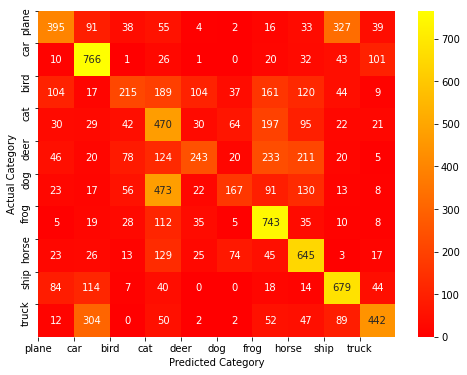

In [25]:
plot_confusion_matrix(net2)

Model 3:

Use SGD optimizer with learning rate = 0.001, momentum = 0.9 and squared error loss
as the loss function.

In [27]:
run=wandb.init(project="50-Epoch_CIFAR-FADML-Utkarsh",reinit=True)
wandb.watch_called = False
net3 = convfc()
wandb.watch(net3,log="all")
net3 = net3.to(device)
running_loss_history = []
val_running_loss_history = []
mse = True
criterion = nn.MSELoss()
optimizer = optim.SGD(net3.parameters(), lr=0.001, momentum=0.9)
train_test_model(net3,criterion,optimizer,mse)

Epoch,49
Training Loss,497.18065
_runtime,1155
_timestamp,1622528486
_step,149
Validation Loss,87.54016
Test Accuracy,47.65
Test Loss,142.48962


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training Loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Validation Loss,██▆▅▄▄▄▄▄▃▅▄▄▄▄▃▃▃▃▂▇▅▃▃▂▃▃▂▂▂▁▂▃▁▂▃▄▁▁▁
Test Accuracy,▁▁▂▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▄▅▇▇▇▇▇▇▇▇█▇▇▇▇▇▆███
Test Loss,██▇▆▄▄▄▄▄▃▄▄▃▄▃▃▃▃▂▂█▅▃▂▂▃▂▂▁▂▁▂▃▂▂▃▃▁▁▁


wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training Model

Epoch: 0
Completed Training
Training Loss: 31

 Training Model

Epochs: 0
Testing Accuracy: 10 


Training Model

Epoch: 1
Completed Training
Training Loss: 30

 Training Model

Epochs: 1
Testing Accuracy: 13 


Training Model

Epoch: 2
Completed Training
Training Loss: 29

 Training Model

Epochs: 2
Testing Accuracy: 15 


Training Model

Epoch: 3
Completed Training
Training Loss: 29

 Training Model

Epochs: 3
Testing Accuracy: 17 


Training Model

Epoch: 4
Completed Training
Training Loss: 29

 Training Model

Epochs: 4
Testing Accuracy: 19 


Training Model

Epoch: 5
Completed Training
Training Loss: 29

 Training Model

Epochs: 5
Testing Accuracy: 20 


Training Model

Epoch: 6
Completed Training
Training Loss: 29

 Training Model

Epochs: 6
Testing Accuracy: 21 


Training Model

Epoch: 7
Completed Training
Training Loss: 29

 Training Model

Epochs: 7
Testing Accuracy: 22 


Training Model

Epoch: 8
Completed Training
Training Loss: 29

 Training Model

Epochs: 

In [28]:
best_param_prediction(net3)

Accuracy for class plane is: 57.8 %
Accuracy for class car   is: 46.2 %
Accuracy for class bird  is: 3.4 %
Accuracy for class cat   is: 1.6 %
Accuracy for class deer  is: 35.6 %
Accuracy for class dog   is: 27.1 %
Accuracy for class frog  is: 59.9 %
Accuracy for class horse is: 40.4 %
Accuracy for class ship  is: 32.4 %
Accuracy for class truck is: 50.2 %


Model accuracy on 10000 test images: 35.46%


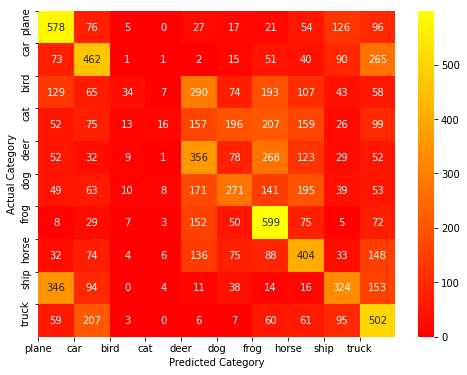

In [29]:
plot_confusion_matrix(net3)

Model 4:

Use Adam optimizer with learning rate = 0.01 and squared error loss as the loss
function.

In [31]:
run=wandb.init(project="50-Epoch_CIFAR-FADML-Utkarsh",reinit=True)
wandb.watch_called = False
net4 = convfc()
wandb.watch(net4,log="all")
net4 = net4.to(device)
running_loss_history = []
val_running_loss_history = []
mse = True
criterion = nn.MSELoss()
optimizer = optim.Adam(net4.parameters(), lr=0.01)
train_test_model(net4,criterion,optimizer,mse)

Epoch,49
Training Loss,26.83054
_runtime,1143
_timestamp,1622530045
_step,149
Validation Loss,4.73874
Test Accuracy,35.46
Test Loss,7.91323


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training Loss,█▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Validation Loss,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Test Accuracy,▁▂▂▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
Test Loss,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁


wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training Model

Epoch: 0
Completed Training
Training Loss: 30

 Training Model

Epochs: 0
Testing Accuracy: 10 


Training Model

Epoch: 1
Completed Training
Training Loss: 30

 Training Model

Epochs: 1
Testing Accuracy: 10 


Training Model

Epoch: 2
Completed Training
Training Loss: 30

 Training Model

Epochs: 2
Testing Accuracy: 10 


Training Model

Epoch: 3
Completed Training
Training Loss: 30

 Training Model

Epochs: 3
Testing Accuracy: 10 


Training Model

Epoch: 4
Completed Training
Training Loss: 30

 Training Model

Epochs: 4
Testing Accuracy: 10 


Training Model

Epoch: 5
Completed Training
Training Loss: 30

 Training Model

Epochs: 5
Testing Accuracy: 10 


Training Model

Epoch: 6
Completed Training
Training Loss: 30

 Training Model

Epochs: 6
Testing Accuracy: 10 


Training Model

Epoch: 7
Completed Training
Training Loss: 30

 Training Model

Epochs: 7
Testing Accuracy: 10 


Training Model

Epoch: 8
Completed Training
Training Loss: 30

 Training Model

Epochs: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d807dc20>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d807dc20>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join

Completed Training
Training Loss: 30


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d807dc20>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d807dc20>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join


 Training Model

Epochs: 10


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d807dc20>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d807dc20>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join

Testing Accuracy: 10 


Training Model

Epoch: 11
Completed Training
Training Loss: 30

 Training Model

Epochs: 11
Testing Accuracy: 10 


Training Model

Epoch: 12
Completed Training
Training Loss: 30

 Training Model

Epochs: 12
Testing Accuracy: 10 


Training Model

Epoch: 13
Completed Training
Training Loss: 30

 Training Model

Epochs: 13
Testing Accuracy: 10 


Training Model

Epoch: 14
Completed Training
Training Loss: 30

 Training Model

Epochs: 14
Testing Accuracy: 10 


Training Model

Epoch: 15
Completed Training
Training Loss: 30

 Training Model

Epochs: 15
Testing Accuracy: 10 


Training Model

Epoch: 16
Completed Training
Training Loss: 30

 Training Model

Epochs: 16
Testing Accuracy: 10 


Training Model

Epoch: 17
Completed Training
Training Loss: 30

 Training Model

Epochs: 17
Testing Accuracy: 10 


Training Model

Epoch: 18
Completed Training
Training Loss: 30

 Training Model

Epochs: 18
Testing Accuracy: 10 


Training Model

Epoch: 19
Completed Training
Tra

In [32]:
best_param_prediction(net4)

Accuracy for class plane is: 0.0 %
Accuracy for class car   is: 100.0 %
Accuracy for class bird  is: 0.0 %
Accuracy for class cat   is: 0.0 %
Accuracy for class deer  is: 0.0 %
Accuracy for class dog   is: 0.0 %
Accuracy for class frog  is: 0.0 %
Accuracy for class horse is: 0.0 %
Accuracy for class ship  is: 0.0 %
Accuracy for class truck is: 0.0 %


Model accuracy on 10000 test images: 10.00%


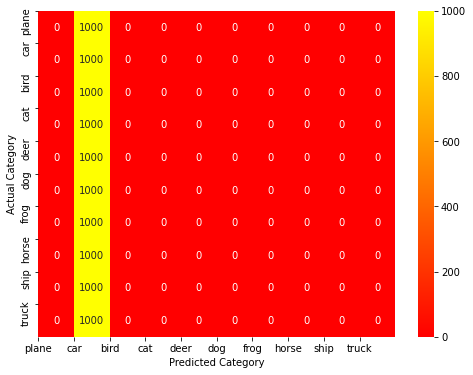

In [33]:
plot_confusion_matrix(net4)

 ResNet34 Model
 
Compare with ResNet34: Extract the pre-trained features (of dimension 512) from the
penultimate layer from ResNet34 module and train a 3 layer neural network of the following
structure:
Layer 1: Input features - 512, Output features - 256
Layer 2: Input features - 256, Output features - 128
Layer 3: Input features - 128, Output - 10


Use SGD optimizer, learning rate = 0.01 , momentum = 0.9 and cross-entropy as the loss
function and train till training loss converges.

In [35]:
rn34 = models.resnet34(pretrained=True)
input_to_fc=rn34.fc.in_features
rn34.fc = nn.Linear(input_to_fc, 256)
rn34.fc1 = nn.Linear(256,128)
rn34.fc2 = nn.Linear(128,10)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [36]:
run=wandb.init(project="50-Epoch_CIFAR-FADML-Utkarsh",reinit=True)
wandb.watch_called = False
rn34 = rn34.to(device)
wandb.watch(rn34,log="all")
running_loss_history = []
val_running_loss_history = []
mse = False
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rn34.parameters(), lr=0.01, momentum=0.9)
train_test_model(rn34,criterion,optimizer,mse)

Epoch,49
Training Loss,30.01386
_runtime,1148
_timestamp,1622531475
_step,149
Validation Loss,5.32077
Test Accuracy,10.0
Test Loss,9.01755


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Validation Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training Model

Epoch: 0
Completed Training
Training Loss: 483

 Training Model

Epochs: 0
Testing Accuracy: 66 


Training Model

Epoch: 1
Completed Training
Training Loss: 355

 Training Model

Epochs: 1
Testing Accuracy: 70 


Training Model

Epoch: 2
Completed Training
Training Loss: 279

 Training Model

Epochs: 2
Testing Accuracy: 74 


Training Model

Epoch: 3
Completed Training
Training Loss: 243

 Training Model

Epochs: 3
Testing Accuracy: 76 


Training Model

Epoch: 4
Completed Training
Training Loss: 219

 Training Model

Epochs: 4
Testing Accuracy: 78 


Training Model

Epoch: 5
Completed Training
Training Loss: 201

 Training Model

Epochs: 5
Testing Accuracy: 79 


Training Model

Epoch: 6
Completed Training
Training Loss: 186

 Training Model

Epochs: 6
Testing Accuracy: 80 


Training Model

Epoch: 7
Completed Training
Training Loss: 174

 Training Model

Epochs: 7
Testing Accuracy: 80 


Training Model

Epoch: 8
Completed Training
Training Loss: 161

 Training Model


In [37]:
best_param_prediction(rn34)

Accuracy for class plane is: 89.0 %
Accuracy for class car   is: 87.8 %
Accuracy for class bird  is: 80.1 %
Accuracy for class cat   is: 67.0 %
Accuracy for class deer  is: 82.2 %
Accuracy for class dog   is: 77.3 %
Accuracy for class frog  is: 87.5 %
Accuracy for class horse is: 83.4 %
Accuracy for class ship  is: 89.8 %
Accuracy for class truck is: 90.0 %


Model accuracy on 10000 test images: 83.41%


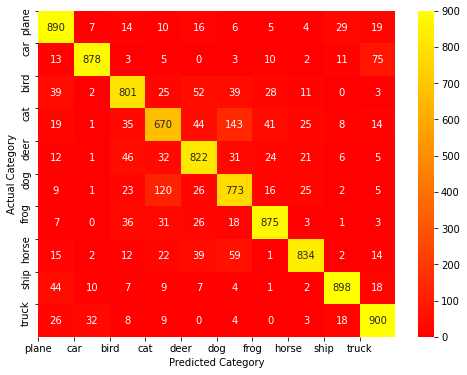

In [38]:
plot_confusion_matrix(rn34)

Sample